In [1]:
"""
Exploratory data analysis for the weather-airports project.

Part 1a: Weather events

Weather data: https://www.kaggle.com/sobhanmoosavi/us-weather-events
Flight delays/cancellations: https://www.transtats.bts.gov/DL_SelectFields.asp
Busiest airports: https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/media/preliminary-cy18-commercial-service-enplanements.pdf

"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pytz
import warnings
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

START_YEAR = 2016
END_YEAR = 2019

In [2]:
'''Data collection'''
stopwatch = TimeTracker.TimeTracker()
# Get all the data.
path = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data'
os.chdir(path)
print('Importing weather events CSV file')
weather_events = pd.read_csv('US_WeatherEvents_2016-2019.csv')

Importing weather events CSV file


In [3]:
# Check for any duplicates.
nRows = len(weather_events.index)
weather_events.drop_duplicates(inplace=True)
print('Any duplicates dropped?', len(weather_events.index)!=nRows) #No duplicates.

Any duplicates dropped? False


A source for the 2019 data was not available at this time, so I assume that the 2018
busiest airport rankings are the same. Either way there should not have been a major
dropoff in passenger numbers at the US's busiest airports between 2018 and 2019.

In [4]:
# Get the busiest airports in the US.
busiest_US_airports2018 = ['ATL','LAX','ORD','DFW','DEN','JFK','SFO','SEA',
                           'LAS','MCO','EWR','CLT','PHX','MIA','IAH','BOS']
busiest_US_airports2018 = pd.Series(
    busiest_US_airports2018, index=range(1, len(busiest_US_airports2018)+1),
    name='Airport')
busiest_US_airports2018.index.name = 'Rank'
busiest_US_airports2018.to_csv('busiest_US_airports2018.csv') #For Part 1b

In [5]:
'''Explore the weather data.'''
# Take a couple airports as a sample
weather_ORD = weather_events[weather_events.AirportCode=='KORD']
print('\nO\'Hare weather events:\n' + str(weather_ORD.Type.value_counts()))
print(weather_ORD.Severity.value_counts())
print('Latitude, Longitude:', weather_ORD.LocationLat.unique(), weather_ORD.LocationLng.unique())

weather_EWR = weather_events[weather_events.AirportCode=='KEWR']
print('\nNewark weather events:\n' + str(weather_EWR.Type.value_counts()))
print(weather_EWR.Severity.value_counts())
print('Latitude, Longitude:', weather_EWR.LocationLat.unique(), weather_EWR.LocationLng.unique())

# Need to see what's going on with Phoenix's time zones
weather_PHX = weather_events[weather_events.AirportCode=='KPHX']
print('\nPhoenix weather events:\n' + str(weather_PHX.Type.value_counts()))
print(weather_PHX.Severity.value_counts()) #Warmer, drier climate
print(weather_PHX.TimeZone.unique()) #Just 'US/Mountain'. PHX is standard time year-round.
print('Latitude, Longitude:', weather_PHX.LocationLat.unique(), weather_PHX.LocationLng.unique(), '\n')
weather_events.loc[(weather_events.AirportCode=='KPHX'), 'TimeZone'] = 'US/Arizona'


O'Hare weather events:
Rain             1903
Snow              566
Fog               235
Precipitation      44
Hail               10
Storm               8
Cold                3
Name: Type, dtype: int64
Light       1859
Moderate     578
Severe       142
Heavy        136
UNK           44
Other         10
Name: Severity, dtype: int64
Latitude, Longitude: [41.9875] [-87.9319]

Newark weather events:
Rain             1945
Snow              297
Fog               114
Precipitation      33
Hail               17
Storm              10
Cold                1
Name: Type, dtype: int64
Light       1648
Moderate     504
Heavy        131
Severe        84
UNK           33
Other         17
Name: Severity, dtype: int64
Latitude, Longitude: [40.6827] [-74.1693]

Phoenix weather events:
Rain             401
Fog               23
Storm              9
Cold               6
Precipitation      2
Hail               1
Name: Type, dtype: int64
Light       335
Moderate     68
Severe       23
Heavy        13
UNK     

In [6]:
# Keep only the airports we need.
ICAO_codes = ('K'+busiest_US_airports2018).to_list()
weather_events.drop(weather_events.index[np.where(~weather_events.AirportCode.isin(ICAO_codes))[0]], inplace=True)

# Recast the 4-lettered ICAO-code index into the 3-lettered IATA codes.
weather_events.rename(columns={'AirportCode': 'Airport'}, inplace=True)
weather_events.Airport = weather_events.Airport.apply(
    lambda prefix: prefix[1:])

# Replace the useless index numbers with default indexing.
weather_events = weather_events.reset_index(drop=True)

In [7]:
# Get the details on our airports
print(weather_events.columns)
unique_airports_weather = weather_events.loc[:, 'TimeZone':'State'].drop_duplicates()
print(unique_airports_weather.index.name, '\n', unique_airports_weather.columns)
unique_airports_weather = unique_airports_weather.drop('County', axis=1)
unique_airports_weather = unique_airports_weather.set_index('Airport')
unique_airports_weather = unique_airports_weather[['City','State','TimeZone','LocationLat','LocationLng']]
print(unique_airports_weather)

Index(['EventId', 'Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)',
       'TimeZone', 'Airport', 'LocationLat', 'LocationLng', 'City', 'County',
       'State', 'ZipCode'],
      dtype='object')
None 
 Index(['TimeZone', 'Airport', 'LocationLat', 'LocationLng', 'City', 'County',
       'State'],
      dtype='object')
                         City State     TimeZone  LocationLat  LocationLng
Airport                                                                   
JFK                   Jamaica    NY   US/Eastern      40.6392     -73.7639
ORD               Bensenville    IL   US/Central      41.9875     -87.9319
BOS               East Boston    MA   US/Eastern      42.3606     -71.0097
DEN                    Denver    CO  US/Mountain      39.8466    -104.6562
MCO                   Orlando    FL   US/Eastern      28.4183     -81.3241
DFW                    Dallas    TX   US/Central      32.8974     -97.0220
EWR                    Newark    NJ   US/Eastern      40.6827     -74.1693
L

In [8]:
# Latitude and longitudes check out. Let's trim extraneous columns.'''
weather_events = weather_events.drop(['EventId','LocationLat','LocationLng',
                                      'County','ZipCode','City','State'], axis=1)
print('Remaining columns:', weather_events.columns)

# '''Get the weather data times into datetime format.'''
print(type(weather_events.iloc[0].loc['StartTime(UTC)']))
print(type(weather_events.iloc[0].loc['EndTime(UTC)'])) #Both are strings.

Remaining columns: Index(['Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)', 'TimeZone',
       'Airport'],
      dtype='object')
<class 'str'>
<class 'str'>


In [9]:
# Convert datetimes and timezones to the right types of objects.
weather_events['StartTime(UTC)'] = pd.to_datetime(weather_events['StartTime(UTC)']).dt.tz_localize('utc')
weather_events['EndTime(UTC)'] = pd.to_datetime(weather_events['EndTime(UTC)']).dt.tz_localize('utc')
weather_events['TimeZone'] = weather_events['TimeZone'].map(pytz.timezone)

# Localize the times to their respective time zones.
print('Converting weather start times to local time zones')
weather_events['StartTimeLocal'] = weather_events.apply(
    lambda row: row['StartTime(UTC)'].tz_convert(row['TimeZone']), axis=1)
print('Converting weather end times to local time zones')
weather_events['EndTimeLocal'] = weather_events.apply(
    lambda row: row['EndTime(UTC)'].tz_convert(row['TimeZone']), axis=1)

Converting weather start times to local time zones
Converting weather end times to local time zones


In [10]:
# We no longer need data outside the relevant year. Remove them and reset the index.
# Irrelevant if all years are selected.
print('Removing entries completely outside the relevant year(s)')
weather_events = weather_events.drop(weather_events[weather_events.apply(
    lambda row: (row['StartTimeLocal'].year > END_YEAR)\
              | (row['EndTimeLocal'].year < START_YEAR), axis=1)].index)
print('Remaining events count:', len(weather_events.index))
weather_events = weather_events.reset_index(drop=True)

Removing entries completely outside the relevant year(s)
Remaining events count: 31126


In [11]:
# Cut the columns just down to the ones we need and reorder them.
print(weather_events.columns)
weather_events = weather_events[['Airport','Type','Severity','StartTimeLocal','EndTimeLocal']]

Index(['Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)', 'TimeZone',
       'Airport', 'StartTimeLocal', 'EndTimeLocal'],
      dtype='object')


In [12]:
# Let's see how many events rolled over New Year's at the endpoints.
print('Events that spanned New Year\'s', START_YEAR, 'or', END_YEAR+1)
events_outside_our_years = weather_events.apply(
    lambda row: (row['StartTimeLocal'].year < START_YEAR)\
        | (row['EndTimeLocal'].year > END_YEAR), axis=1)
print(weather_events[events_outside_our_years]) #None!

Events that spanned New Year's 2016 or 2020
Empty DataFrame
Columns: [Airport, Type, Severity, StartTimeLocal, EndTimeLocal]
Index: []


In [13]:
'''Investigate weather types and declare numeric variables for them.
Begin transitioning to the daily_weather DataFrame.'''
print(weather_events.Type.value_counts())
for weatherType in weather_events.Type.unique():
    print('\nSeverities for weather type ' + weatherType + ':')
    print(weather_events[weather_events.Type==weatherType].Severity.value_counts())
print('\nSeverities for all types:\n', weather_events.Severity.value_counts())

Rain             24127
Fog               3811
Snow              2306
Precipitation      553
Storm              172
Hail               110
Cold                47
Name: Type, dtype: int64

Severities for weather type Rain:
Light       18506
Moderate     4251
Heavy        1370
Name: Severity, dtype: int64

Severities for weather type Fog:
Moderate    1932
Severe      1879
Name: Severity, dtype: int64

Severities for weather type Snow:
Light       1570
Moderate     561
Heavy        175
Name: Severity, dtype: int64

Severities for weather type Precipitation:
UNK    553
Name: Severity, dtype: int64

Severities for weather type Hail:
Other    110
Name: Severity, dtype: int64

Severities for weather type Storm:
Severe    172
Name: Severity, dtype: int64

Severities for weather type Cold:
Severe    47
Name: Severity, dtype: int64

Severities for all types:
 Light       20076
Moderate     6744
Severe       2098
Heavy        1545
UNK           553
Other         110
Name: Severity, dtype: int64


Rain: Light, Moderate, Heavy<br>
Fog: Moderate, Severe<br>
Snow: Light, Moderate, Heavy<br>
Precipitation: UNK (we need to fix this)<br>
Hail: Other<br>
Storm: Severe<br>
Cold: Severe<br>

In [14]:
daily_weather = weather_events.copy()

DF_width = len(daily_weather.columns) #get this now before new columns added
daily_weather['HailCode'] = (daily_weather.Type == 'Hail').map(int)
daily_weather['StormCode'] = (daily_weather.Type == 'Storm').map(int)
daily_weather['ColdCode'] = (daily_weather.Type == 'Cold').map(int)

LightModerateHeavy = {'Light':1, 'Moderate':2, 'Heavy':3}
daily_weather['RainCode'] =\
    daily_weather[daily_weather.Type=='Rain'].Severity.map(LightModerateHeavy)
daily_weather.RainCode = daily_weather.RainCode.fillna(value=0)
daily_weather['FogCode'] =\
    daily_weather[daily_weather.Type=='Fog'].Severity.map({'Moderate':1, 'Severe':2})
daily_weather.FogCode = daily_weather.FogCode.fillna(value=0)
daily_weather['SnowCode'] =\
    daily_weather[daily_weather.Type=='Snow'].Severity.map(LightModerateHeavy)
daily_weather.SnowCode = daily_weather.SnowCode.fillna(value=0)
FIRST_WEATHER_CODE = (daily_weather.columns)[DF_width] #needed later

In [15]:
#Fix the "Precipitation" and "UNK" entries.
PRECIP = 'Precipitation'; UNK = 'UNK'
print('Count of "' + PRECIP + '" XOR "' + UNK + ':"', len(daily_weather\
    [((daily_weather.Type == PRECIP) &
      (daily_weather.Severity != UNK)) |
      ((daily_weather.Type != PRECIP) &
      (daily_weather.Severity == UNK))].index)) #Perfect match!

Count of "Precipitation" XOR "UNK:" 0


In [16]:
print('\nImputing these events')
for airport in busiest_US_airports2018:
    airport_indeces = daily_weather[daily_weather.Airport == airport].index
    if airport_indeces.size > 0:
        assert np.max(np.diff(airport_indeces)) == 1,\
            'Indexes misaligned for ' + str(airport)
        weather_current_airport = daily_weather.loc[airport_indeces]
        unknown_precip_indeces = weather_current_airport\
            [weather_current_airport.Type == PRECIP].index
        if len(unknown_precip_indeces)==0:
            print(airport, 'has no unknown precipitation')
        else:
            weather_before_indeces = unknown_precip_indeces-1
            weather_after_indeces = unknown_precip_indeces+1
            try:
                weather_current_airport.loc[weather_before_indeces[0]]
            except KeyError:
                raise ValueError('First weather event at', airport, 'is unknown precip')
            try:
                weather_current_airport.loc[weather_after_indeces[-1]]
            except KeyError:
                raise ValueError('Last weather event at', airport, 'is unknown precip')
            # Will need to code a workaround if either of these issues arise.
        
            # Impute based on averages from entries immediately before and after.
            # Round up decimals to nearest integer.
            imputation_values = np.ceil((
                weather_current_airport.loc[weather_before_indeces, FIRST_WEATHER_CODE:].values
                + weather_current_airport.loc[weather_after_indeces, FIRST_WEATHER_CODE:].values)/2).astype(int)
            for i, index in enumerate(unknown_precip_indeces):
                daily_weather.loc[index, FIRST_WEATHER_CODE:] = imputation_values[i]
    else:
        print(airport, 'has no entries')


Imputing these events


In [17]:
print(daily_weather.columns)
daily_weather = daily_weather.drop(['Type', 'Severity'], axis=1)

Index(['Airport', 'Type', 'Severity', 'StartTimeLocal', 'EndTimeLocal',
       'HailCode', 'StormCode', 'ColdCode', 'RainCode', 'FogCode', 'SnowCode'],
      dtype='object')


Longest weather event: 23.1 hours


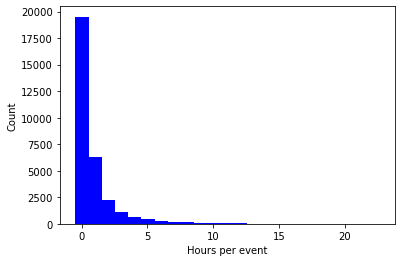

In [18]:
# Analyze the lengths of the weather events.
weather_duration = daily_weather.apply(
    lambda row: (row['EndTimeLocal'] - row['StartTimeLocal']).seconds/3600, axis=1)
longestEvent = max(weather_duration)
print('Longest weather event: %.1f hours' % longestEvent) # <24 hours. Good.
plt.hist(weather_duration, bins=int(longestEvent), color='b', align='left')
plt.xlabel('Hours per event')
plt.ylabel('Count')
plt.savefig(r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\figures\HoursPerWeatherEvent.png')
plt.show() #Most events are < 2 hours, and almost all are < 8 hours.

In [19]:
# Organize events by date
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    daily_weather['StartDate'] = daily_weather.apply(lambda row: row['StartTimeLocal'].date(), axis=1)
    daily_weather['EndDate'] = daily_weather.apply(lambda row: row['EndTimeLocal'].date(), axis=1)
weather_starts = daily_weather.copy()
weather_ends = daily_weather.copy()
weather_starts = weather_starts.drop(['StartTimeLocal','EndTimeLocal','EndDate'], axis=1)
weather_ends = weather_ends.drop(['StartTimeLocal','EndTimeLocal','StartDate'], axis=1)

In [20]:
# Form a pivot table based on the highest precip code in each column per day.
weather_starts = pd.pivot_table(data=weather_starts, index=['Airport','StartDate'], aggfunc=np.max)
weather_ends = pd.pivot_table(data=weather_ends, index=['Airport','EndDate'], aggfunc=np.max)

# Append weather_starts and weather_ends (the columns are the same).
# We no longer need the daily_weather DF, so name the result that.
daily_weather = weather_starts.append(weather_ends).sort_index()

# Find the max over each date and rename the index.
daily_weather = pd.pivot_table(data=daily_weather, index=['Airport','StartDate'], aggfunc=np.max)
daily_weather.index.names = ['Airport','Date']
print(daily_weather.head())

weather_codes = pd.Series(daily_weather.columns)

                    ColdCode  FogCode  HailCode  RainCode  SnowCode  StormCode
Airport Date                                                                  
ATL     2016-01-08         0      0.0         0       2.0       0.0          0
        2016-01-09         0      2.0         0       1.0       0.0          0
        2016-01-10         0      0.0         0       1.0       0.0          0
        2016-01-15         0      2.0         0       3.0       0.0          0
        2016-01-16         0      2.0         0       0.0       0.0          0


In [21]:
#Get the correlation matrix of data with X's features as columns.
def corrMatrixAndMax(df, labels=weather_codes):
    corr = df.corr()
    n = corr.shape[0]
    max_corr_ID = np.argmax(np.abs(corr) - np.eye(n))
    return corr, np.unravel_index(max_corr_ID, [n,n])

#Get the value, and row and column labels of a particular df coordinate. Rounding is arbitrary.
def getCorrNameCoords(df, coordinates):
    row = coordinates[0]; col = coordinates[1]
    return round(df.iloc[row, col], 3), df.index[row], df.index[col]

Total runtime: --- 37.45 seconds ---


In [ ]:
corr, coords_max_corr = corrMatrixAndMax(daily_weather)
print('\nWeather code correlation matrix:\n' + str(corr))
print('Greatest correlation:', getCorrNameCoords(corr, coords_max_corr))

Hail and Snow have a correlation of 0.167. This is suspicious. Hail is a warm-weather event;
snow is a cold-weather event. Let's look at the Hail and Snow codes to see how much overlap there is.

In [ ]:
def SumByPair(df, label1, label2):
    return df.groupby([label1, label2]).size().reset_index().rename(columns={0:'count'})

In [ ]:
print('\nHail and snow code counts:\n' + str(SumByPair(daily_weather, 'HailCode', 'SnowCode')))

Nearly half the Hail=1 codes are correlated with Snow>0 codes. This is a problem,
and we need to investigate it. Let's take a look at these 35 days in the departure
and arrival events DataFrames.